# Unsupervised Machine Learning Final Project: Categorizing Students

Author: Kameron Scott

**NOTE**: a summary will be provided at the bottom for ease of grading. Simply collapse the heading above to reach it quickly. 

If any information from the rubric appears to be missing in the summary, please check the notebook for it, as much more detail is provided in the analyses.

## Objective and Overview

In this notebook, we will be exploring the [Students Performance Dataset](https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset/data) from Kaggle.

More specifically, we will be attempting to identify clusters of students based on a variety of features. (more in the "Loading and Describing our Dataset" section)

We will incorporate three different model types, evaluate their performance, and ultimately select the model best suited to describing our dataset. Since we will be using different metrics for each model, we will use one of our columns that may serve as a reference point for the number of clusters expected. We will also attempt to assess the flexibility of the model, and see if it can potentially identify clusters outside our those of our reference column.

The model types we will be testing include: K-Modes/K-Prototypes clustering, Hierarchical Clusetering (Gower metric), and DBSCAN.

## Preparation

Before we get started, we will need to handle some housekeeping.

### Import necessary libraries and define helper functions

In [1]:
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_feature_distributions(df_: pl.DataFrame, f_columns):
    fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 20))

    axes = axes.flatten()

    for i, col in enumerate(f_columns):
        sns.histplot(df_[col], ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
    
    for i in range(len(f_columns), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

### Loading and describing our dataset

As mentioned in the Objective, we will be using the [Students Performance Dataset](https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset/data) from Kaggle.

Our dataset includes 2392 rows, and 15 columns.

Features:

- `StudentID` : A unique identifier assigned to each student (1001 to 3392)

- `Age` : The age of the student (ranges from 15 to 18 years old)

- `Gender` : the gender of the student (0: male, 1: female)

- `Ethnicity` : The ethnicity of the student (coded as: 0-caucasian, 1-African American, 2-Asian, 3-other)

- `ParentalEducation` : The highest education level achieved by the student's parent (0: None, 1: High School, 2: Some College, 3: Bachelor's, 4: Higher)

- `StudyTimeWeekly` : The time spent weekly on studying (in hours)

- `Absences` : The number of absences during the school year

- `Tutoring` : Whether the student is receiving tutoring (0: No, 1: Yes)

- `ParentalSupport` : The degree of support offered to the student by the parents (ranges from 0 to 4; 0 being none, 4 being very high)

- `Extracurricular` : Whether the student participates in any extracurricular activity (0: No, 1: Yes)

- `Sports` : Whether the student participates in a sport (0: No, 1: Yes)

- `Music` : Whether the student participates in music activities (0: No, 1: Yes)

- `Volunteering` : Whether the student participates in volunteering (0: No, 1: Yes)

- `GPA` : The grade point average of the student (4.0 scale)

- `GradeClass` : A classification of the students' grades based on GPA (
    0: 'A' (GPA >= 3.5)
    1: 'B' (3.0 <= GPA < 3.5)
    2: 'C' (2.5 <= GPA < 3.0)
    3: 'D' (2.0 <= GPA < 2.5)
    4: 'F' (GPA < 2.0))

We begin by reading in our dataset from the csv file.

We also drop the "StudentID" column, since it offers no information pertaining to the objective.

In [3]:
df = pl.read_csv("Student_performance_data.csv")
df = df.drop("StudentID")
df.head()

Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,f64,f64
17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
15,0,2,3,4.21057,26,0,2,0,0,0,0,0.112602,4.0
17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


Let's group our columns by type, and decide what might be necessary to do with each group.

- binary features: Gender, Tutoring, Extracurricular, Sports, Music, Volunteering

- other categorical: Age, Ethnicity

- ordinal: ParentalEducation, ParentalSupport, GradeClass

- numerical: StudyTimeWeekly, Absences, GPA

All of our binary features, aside from Gender, could potentially be combined into a single numerical feature representing the degree of activity outside of school. In an attempt to try and capture the importances of each of these categories, however, we will keep them as they are.

Age is a bit of a weird one. It can be thought of to behave similarly to gender or ethnicity in this case, since the influence its magnitude may have on the other features isn't clear. In some cases, it could be seen as categorical.
The values within our 

Ethnicity column are each distinct, and there's no ordinal nature to them. Because of this, we will end up one-hot encoding these.

Our "ordinal" columns can be treated as numerical, as a higher value generally means "more" or "better" for these. The GradeClass column, however, is ordered in reverse, so we will reverse the scale for consistency with the GPA scale.

StudyTimeWeekly, Absences, and GPA are all well understood numerical features, and so we will simply scale these as necessary for the models we will be employing. 

In [4]:
dfc = df.__copy__()

# perform one-hot encoding
dfc = dfc.to_dummies("Ethnicity")

# invert the scale for "GradeClass"
dfc = dfc.with_columns((4.0 - pl.col("GradeClass")).alias("GradeClass"))

dfc.head()

Age,Gender,Ethnicity_0,Ethnicity_1,Ethnicity_2,Ethnicity_3,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
i64,i64,u8,u8,u8,u8,i64,f64,i64,i64,i64,i64,i64,i64,i64,f64,f64
17,1,1,0,0,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
18,0,1,0,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,3.0
15,0,0,0,1,0,3,4.21057,26,0,2,0,0,0,0,0.112602,0.0
17,1,1,0,0,0,3,10.028829,14,0,3,1,0,0,0,2.054218,1.0
17,1,1,0,0,0,2,4.672495,17,1,3,0,0,0,0,1.288061,0.0


We will use the following sets to be able to dynamically select features we do or don't want to include in our model training.

In [5]:
categorical_cols = {"Age", "Gender", "Ethnicity_0", "Ethnicity_1", "Ethnicity_2", "Ethnicity_3",
                    "ParentalEducation", "Tutoring", "ParentalSupport", "Extracurricular",
                    "Sports", "Music", "Volunteering", "GradeClass"}

numerical_cols = {"StudyTimeWeekly", "Absences", "GPA"}

ordinal_cols = {"ParentalEducation", "ParentalSupport", "StudyTimeWeekly", "Absences", "GPA", "GradeClass"}

Since we will be using various distance metrics for determining similarity between samples, we need to ensure that our features are properly scaled so as to not indirectly influence the weight of any particular feature. Additionally, we will normalize feature distributions where possible.

Let's inspect the initial distributions.

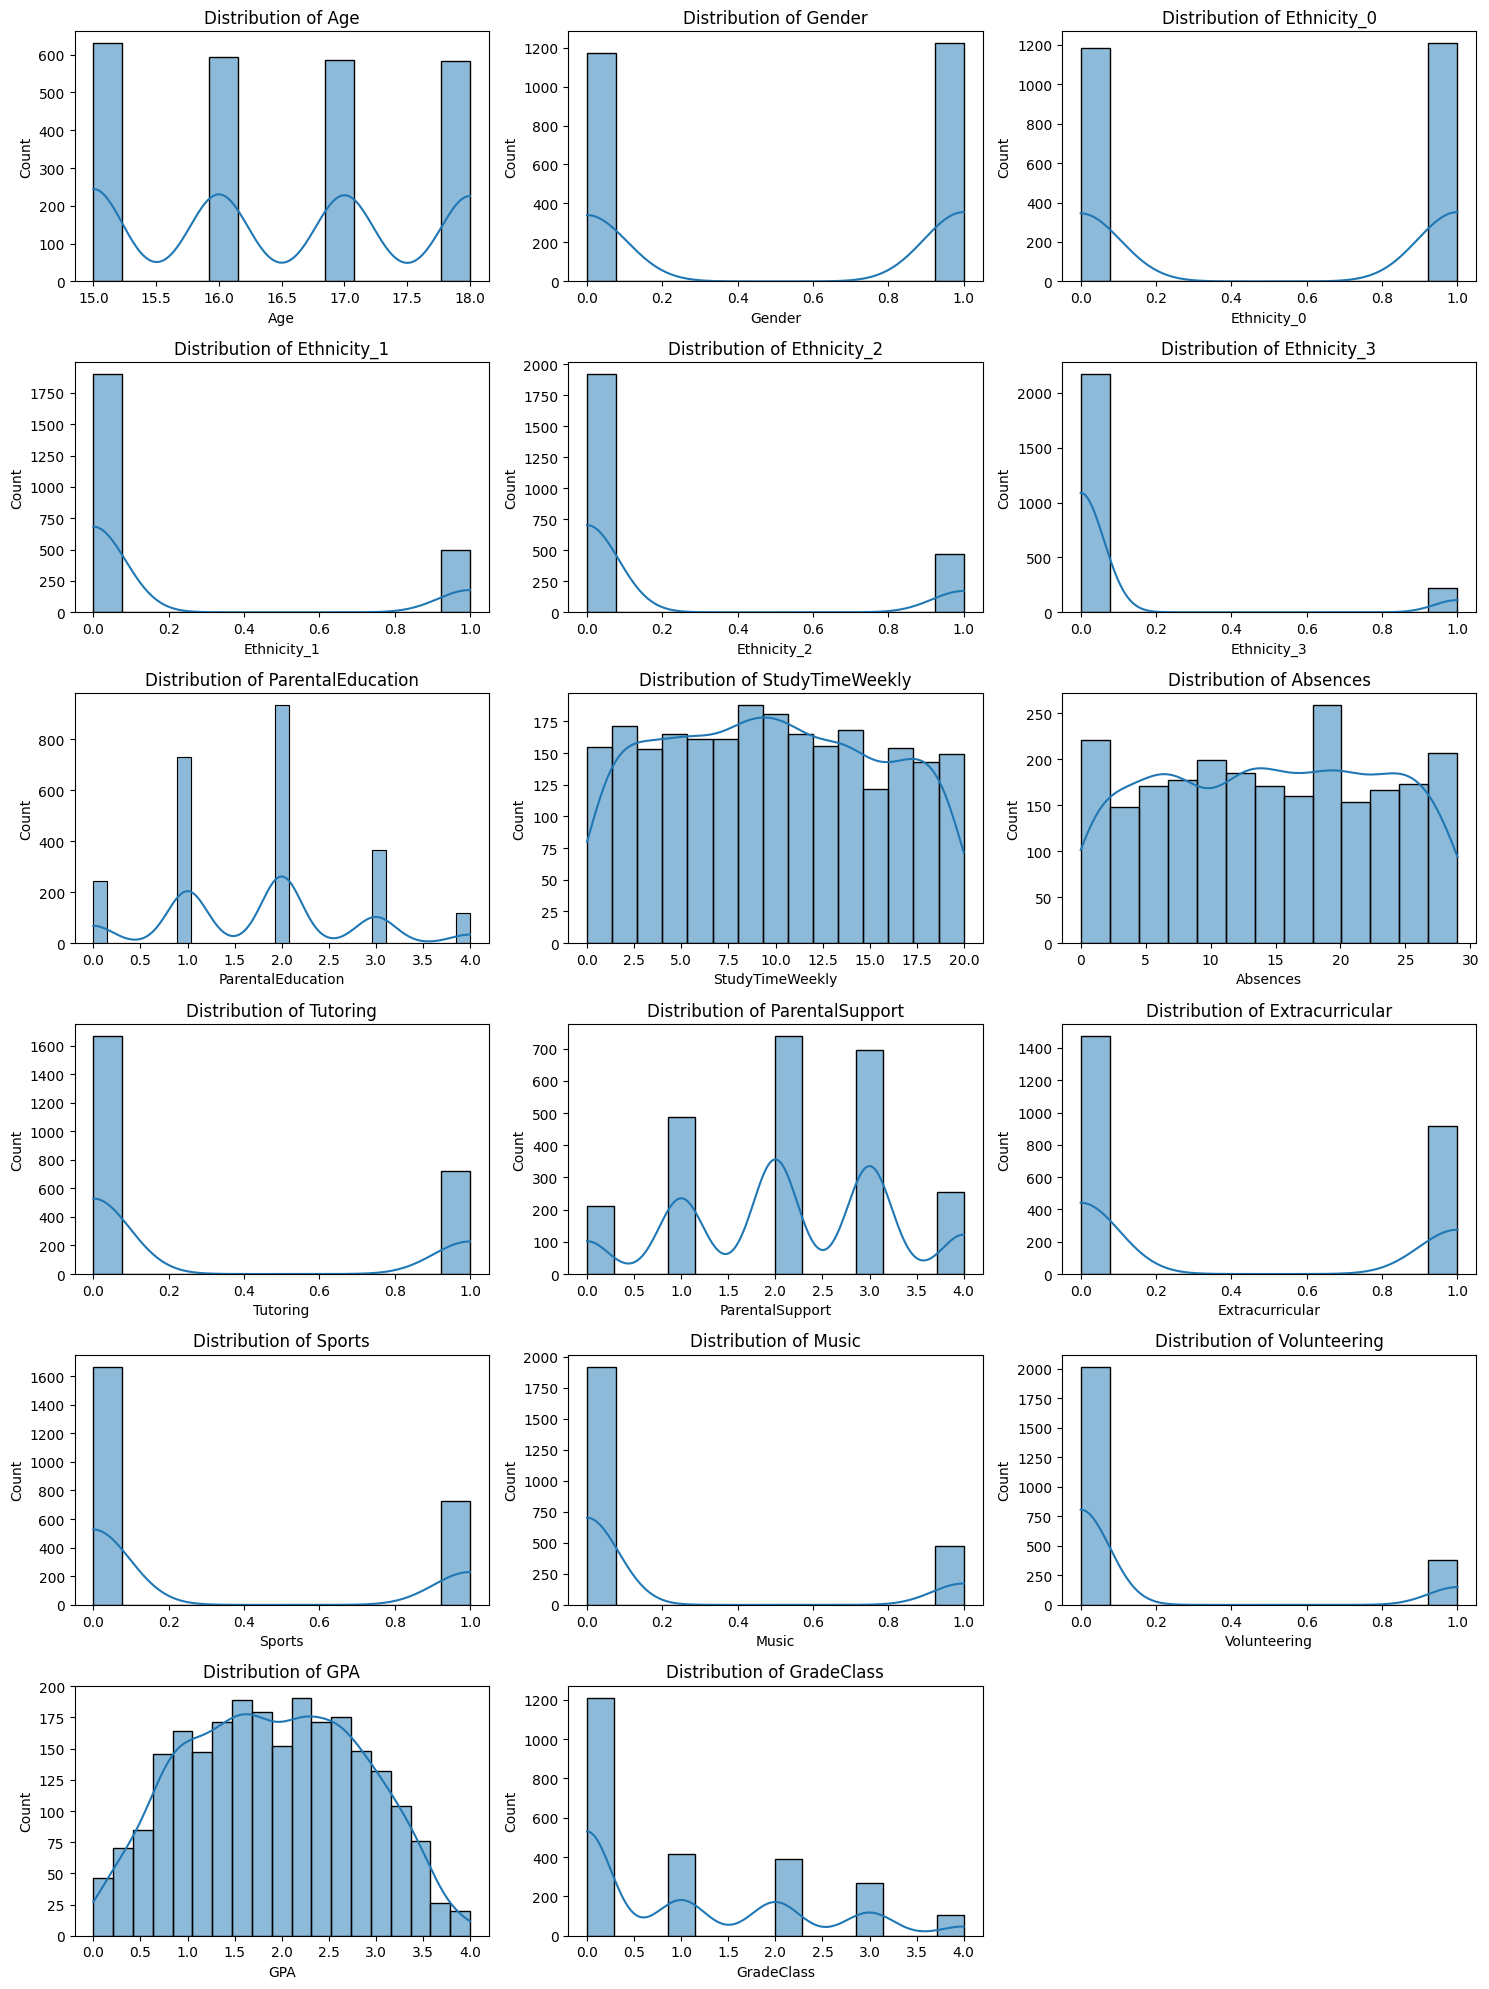

In [6]:
plot_feature_distributions(dfc, dfc.columns)

We should be able to fit `StudyTimeWeekly`, `Absences`, and `GPA` to normal distributions. 

For all features not currently in the range of 0 to 1, we will apply min-max scaling, as this range is preferrable for the models we will be using, and keeps all features on the same scale.

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, QuantileTransformer
import pandas as pd

dft = dfc.to_pandas()

mms = MinMaxScaler()
qt = QuantileTransformer(output_distribution='normal', random_state=42)

dft['Age'] = mms.fit_transform(pd.DataFrame(dft['Age']))

dft['StudyTimeWeekly'] = qt.fit_transform(pd.DataFrame(dft['StudyTimeWeekly']))
dft['StudyTimeWeekly'] = mms.fit_transform(pd.DataFrame(dft['StudyTimeWeekly']))

dft['Absences'] = qt.fit_transform(pd.DataFrame(dft['Absences']))
dft['Absences'] = mms.fit_transform(pd.DataFrame(dft['Absences']))

dft['GPA'] = qt.fit_transform(pd.DataFrame(dft['GPA']))
dft['GPA'] = mms.fit_transform(pd.DataFrame(dft['GPA']))

dft['ParentalEducation'] = mms.fit_transform(pd.DataFrame(dft['ParentalEducation']))

dft['ParentalSupport'] = mms.fit_transform(pd.DataFrame(dft['ParentalSupport']))

dft['GradeClass'] = mms.fit_transform(pd.DataFrame(dft['GradeClass']))


dfc = pl.DataFrame(dft)

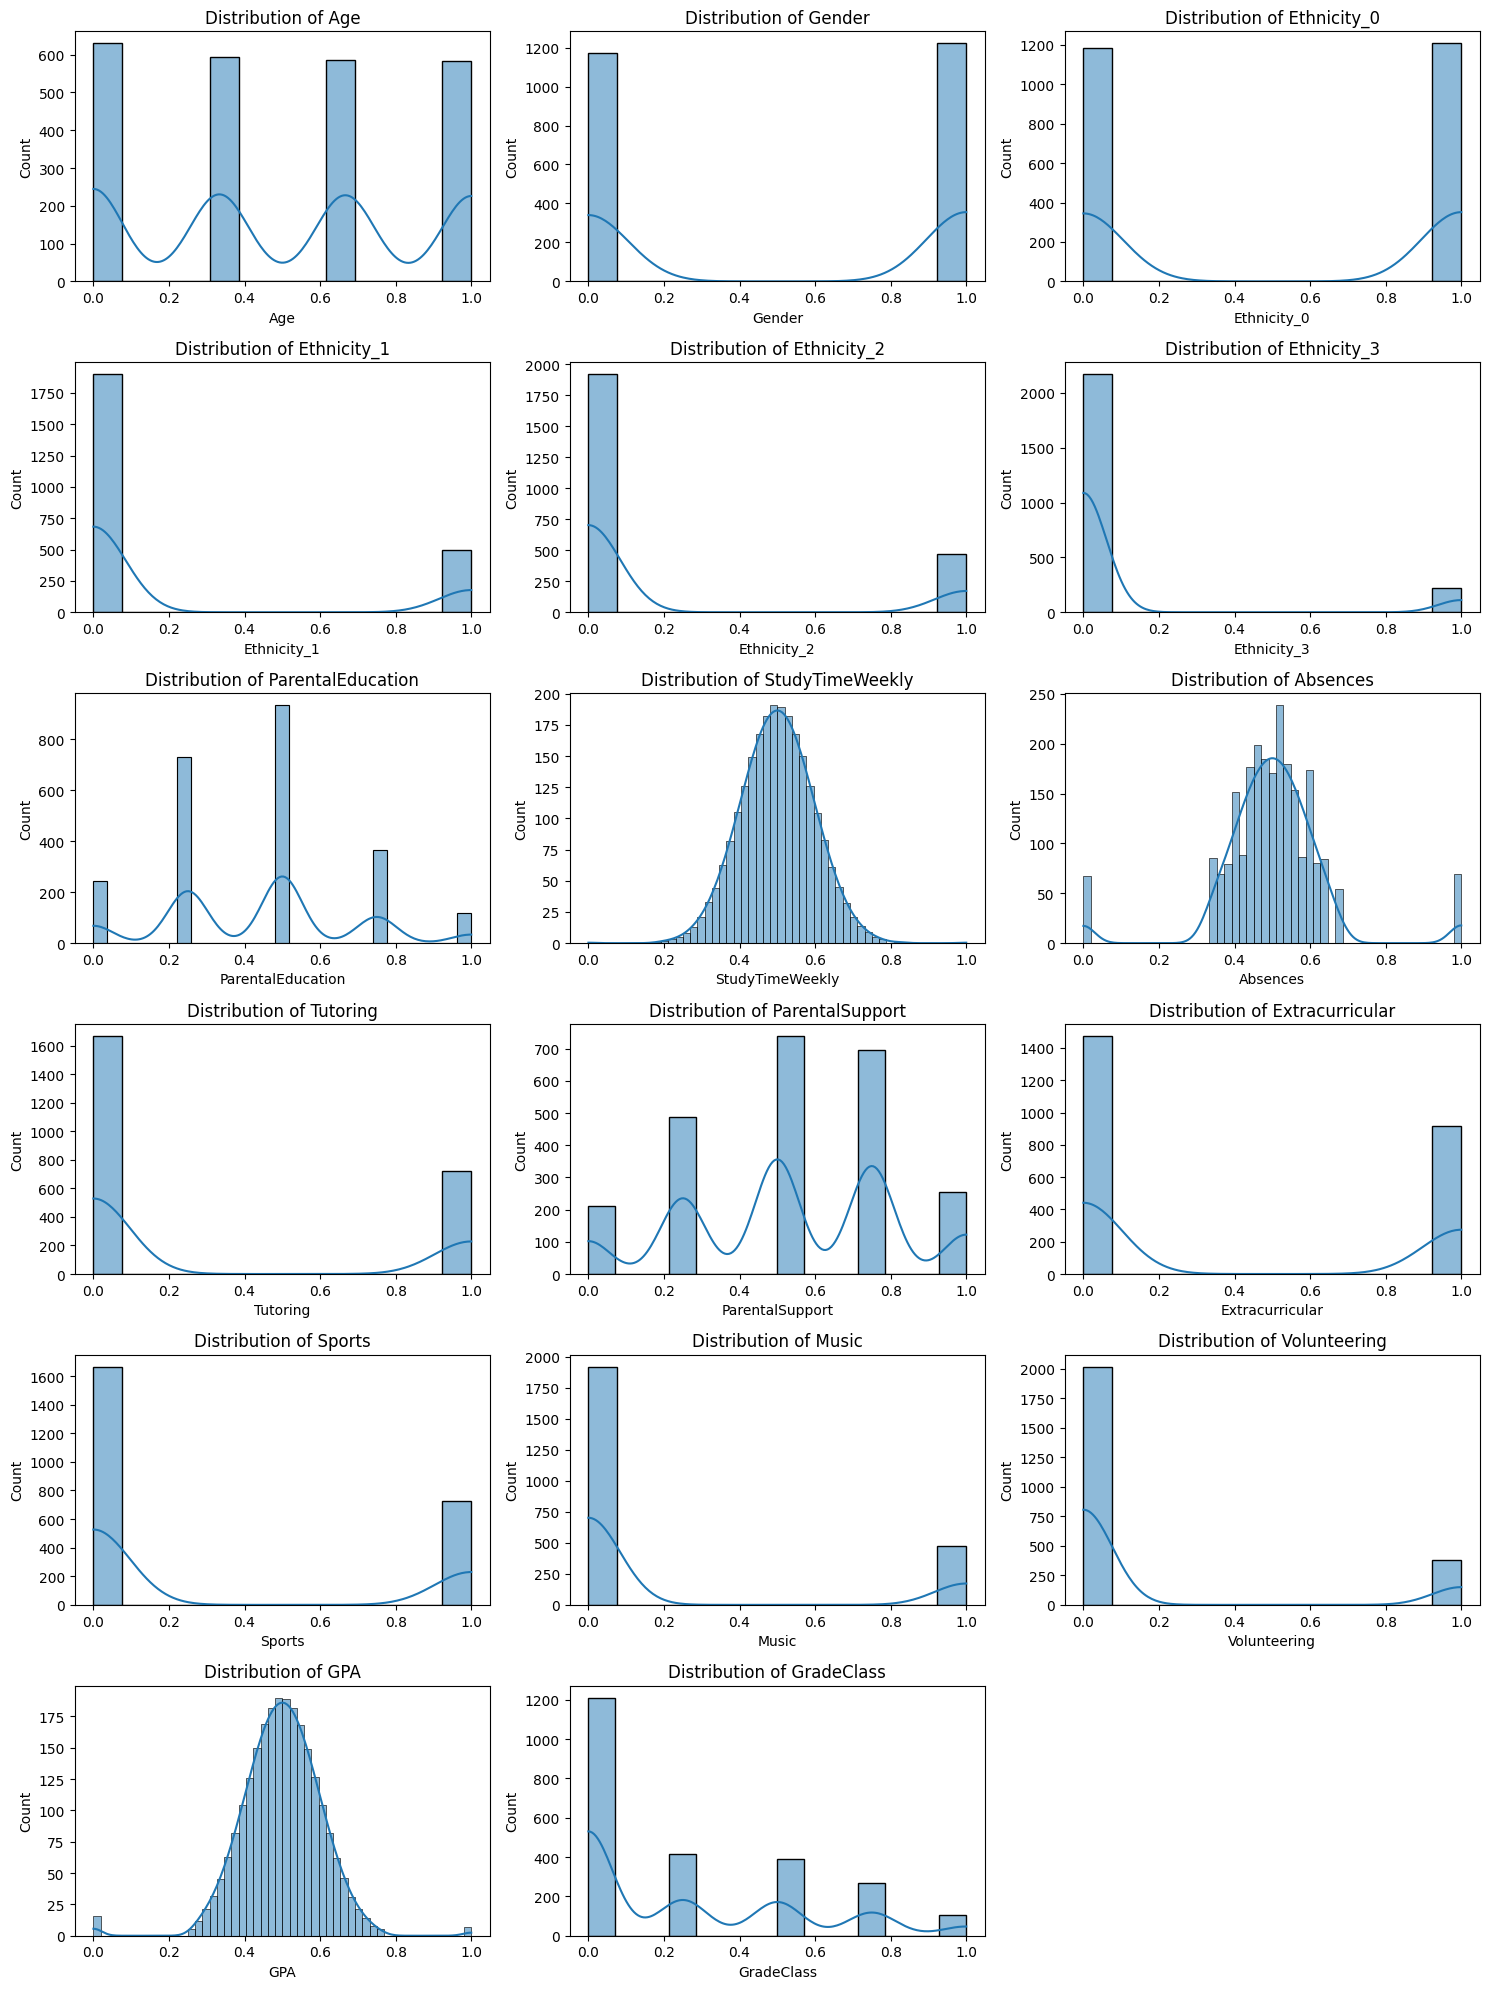

In [8]:
plot_feature_distributions(dfc, dfc.columns)

## Model Training

### K-Modes & K-Prototype Clustering

#### K-Modes

For training a K-Modes model, we will need to exclude the numerical features, since the model is designed to operate on data that is not continuous.

K-modes can handle our columns that are ordinal-categorical (e.g. `ParentalEducation` and `ParentalSupport`), but it does not treat any of the values as being "higher" or "lower" than another; it only checks for dissimilarity. Due to this, we will lose any information about the ordinality of these features.

In [10]:
dfc_categorical = dfc[list(categorical_cols)]

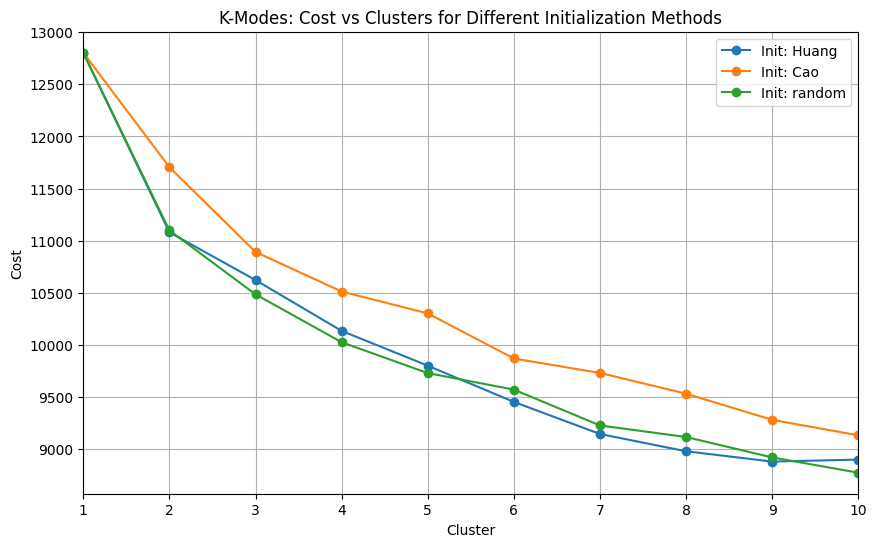

In [11]:
from kmodes.kmodes import KModes
import pandas as pd


plot_data_dict = {}


for init in ["Huang", "Cao", "random"]:
    kmodes_list = list()

    for clust in range(1,11):
        kmodes = KModes(n_clusters=clust, init=init, n_init=10, n_jobs=-1, random_state=42, max_iter=10000)
        kmodes = kmodes.fit(dfc_categorical)
        kmodes_list.append(pd.Series({'clusters': clust, 
                                    'cost': kmodes.cost_,
                                    'model': kmodes}))

    plot_data = (pd.concat(kmodes_list, axis=1)
                .T
                [['clusters','cost']]
                .set_index('clusters'))
    
    plot_data_dict[init] = plot_data


plt.figure(figsize=(10, 6))
for init, plot_data in plot_data_dict.items():
    plt.plot(plot_data.index, plot_data['cost'], marker='o', linestyle='-', label=f'Init: {init}')

plt.xticks(range(0, 11, 1))
plt.xlim(1, 10)
plt.xlabel('Cluster')
plt.ylabel('Cost')
plt.title('K-Modes: Cost vs Clusters for Different Initialization Methods')
plt.legend()
plt.grid(True)
plt.show()

The curves all decrease rather steadily, so there isn't a very discernable "elbow".

There are a couple areas where some curves do flatten somewhat. For the `Cao` initialization method, we get a slight elbow at 6 clusters, and a similarly slight elbow for the other two initialization methods around 7 clusters.

This is interesting to see, as we have 5 `GradeClass` values. So it's possible that we are capturing some additional valid clustering with the features used here.

This data includes the "GradeClass" column, which could serve as target categories for this dataset.

Let's run this test again without the "GradeClass" column as well for comparison.

In [12]:
dfc_categorical_no_GC = dfc_categorical.drop("GradeClass")

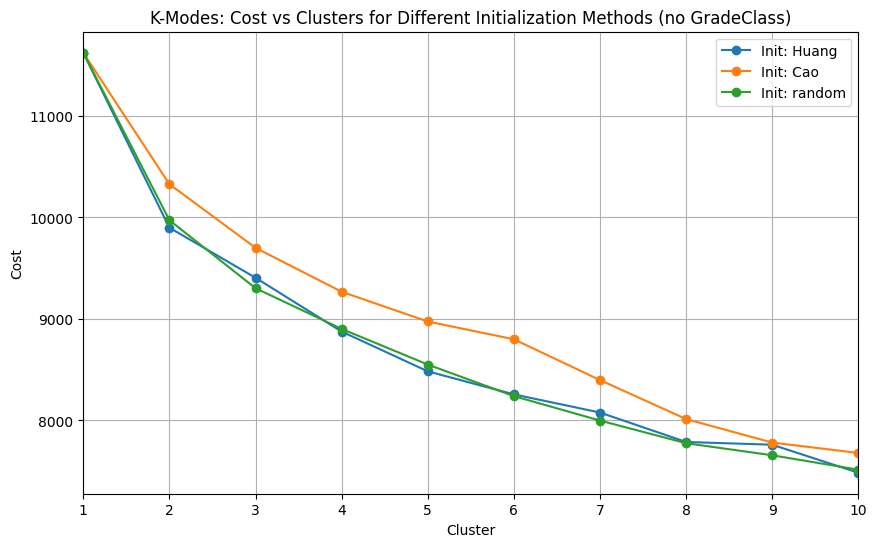

In [13]:
from kmodes.kmodes import KModes
import pandas as pd


plot_data_dict = {}


for init in ["Huang", "Cao", "random"]:
    kmodes_list = list()

    for clust in range(1,11):
        kmodes = KModes(n_clusters=clust, init=init, n_init=10, n_jobs=-1, random_state=42, max_iter=10000)
        kmodes = kmodes.fit(dfc_categorical_no_GC)  # introduce new dataframe here
        kmodes_list.append(pd.Series({'clusters': clust, 
                                    'cost': kmodes.cost_,
                                    'model': kmodes}))

    plot_data = (pd.concat(kmodes_list, axis=1)
                .T
                [['clusters','cost']]
                .set_index('clusters'))
    
    plot_data_dict[init] = plot_data


plt.figure(figsize=(10, 6))
for init, plot_data in plot_data_dict.items():
    plt.plot(plot_data.index, plot_data['cost'], marker='o', linestyle='-', label=f'Init: {init}')

plt.xticks(range(0, 11, 1))
plt.xlim(1, 10)
plt.xlabel('Cluster')
plt.ylabel('Cost')
plt.title('K-Modes: Cost vs Clusters for Different Initialization Methods (no GradeClass)')
plt.legend()
plt.grid(True)
plt.show()

It appears we were able to reduce our overall cost for each `n_clusters` by simply dropping our potential target column.

We can see that our peak cost was reduced by about 2000, and our minimum cost was reduced by around 1000.

Despite this reduction in cost, we seem to have lost the elbows we observed previously. 

Each of our curves appear to have different regions where they are flattest, however.

Let's continue onto K-prototypes, where we can attempt to include our numerical features as well.

#### K-Prototypes

We can try and include the numerical features by utilizing the k-prototypes algorithm instead of k-Modes. 

k-protoypes is a hybridization of k-means and k-modes, allowing us to cluster based off continuous and categorical data.

Additionally, we can retain some of the ordinality from features like `ParentalEducation`, which was lost in k-modes. We achieve this by treating the ordinal-categorical columns as numerical, and so the k-means portion of k-prototypes will handle them.

As before, let's begin by including as many columns as we can. In this case, we should be able to include all of our columns!

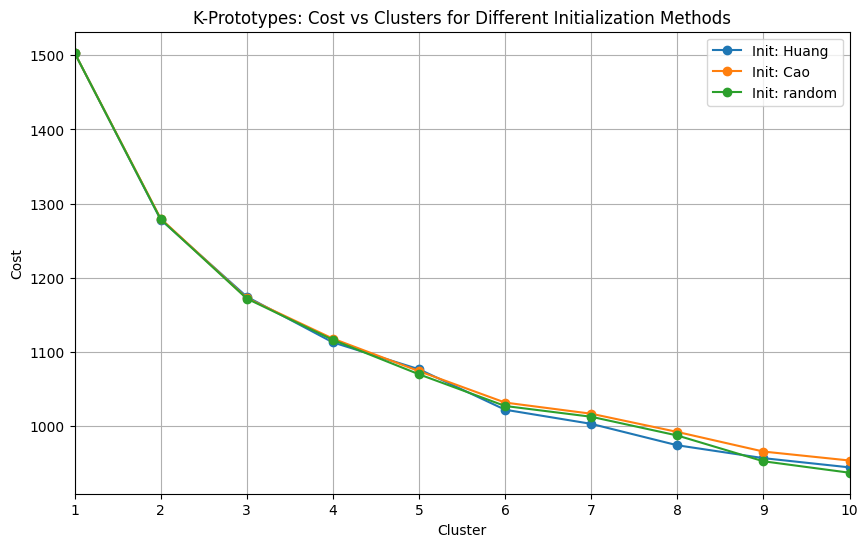

In [14]:
from kmodes.kprototypes import KPrototypes
import pandas as pd


plot_data_dict = {}

# specify the indecies of the categorical columns; necessary for k-prototypes
cat_cols_idx = [i for i, col in enumerate(dfc.columns) if (col in categorical_cols) and (col not in ordinal_cols)]

for init in ["Huang", "Cao", "random"]:
    kptypes_list = list()

    for clust in range(1,11):
        kptypes = KPrototypes(n_clusters=clust, init=init, n_init=10, n_jobs=-1, random_state=42, max_iter=10000)
        kptypes = kptypes.fit(dfc, categorical=cat_cols_idx)
        kptypes_list.append(pd.Series({'clusters': clust, 
                                    'cost': kptypes.cost_,
                                    'model': kptypes}))

    plot_data = (pd.concat(kptypes_list, axis=1)
                .T
                [['clusters','cost']]
                .set_index('clusters'))
    
    plot_data_dict[init] = plot_data


plt.figure(figsize=(10, 6))
for init, plot_data in plot_data_dict.items():
    plt.plot(plot_data.index, plot_data['cost'], marker='o', linestyle='-', label=f'Init: {init}')

plt.xticks(range(0, 11, 1))
plt.xlim(1, 10)
plt.xlabel('Cluster')
plt.ylabel('Cost')
plt.title('K-Prototypes: Cost vs Clusters for Different Initialization Methods')
plt.legend()
plt.grid(True)
plt.show()

We already see a substantial reduction in the cost with k-prototypes (almost 90%)!

Our curve is very consistent and gradual, except for a slight elbow at 8 clusters on our Huang-initialization curve, and another slight elbow around 6 clusters for all our curves.

Let's drop the `GradeClass` column and run the training again for a more complete comparison with our k-modes test.

In [15]:
dfc_no_GC = dfc.drop("GradeClass")

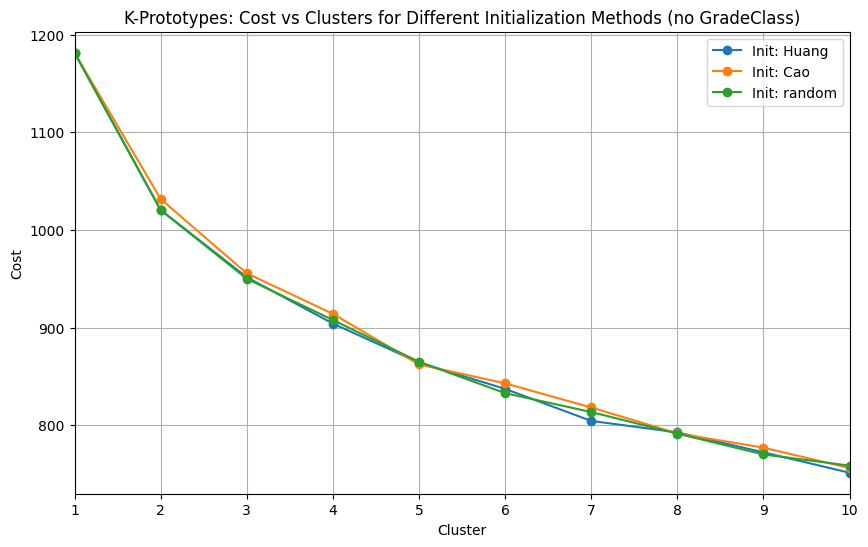

In [16]:
from kmodes.kprototypes import KPrototypes
import pandas as pd


plot_data_dict = {}

cat_cols_idx = [i for i, col in enumerate(dfc_no_GC.columns) 
                if (col in categorical_cols) and (col not in ordinal_cols)]

for init in ["Huang", "Cao", "random"]:
    kptypes_list = list()

    for clust in range(1,11):
        kptypes = KPrototypes(n_clusters=clust, init=init, n_init=10, n_jobs=-1, random_state=42, max_iter=10000)
        kptypes = kptypes.fit(dfc_no_GC, categorical=cat_cols_idx)
        kptypes_list.append(pd.Series({'clusters': clust, 
                                    'cost': kptypes.cost_,
                                    'model': kptypes}))


    plot_data = (pd.concat(kptypes_list, axis=1)
                .T
                [['clusters','cost']]
                .set_index('clusters'))
    
    plot_data_dict[init] = plot_data


plt.figure(figsize=(10, 6))
for init, plot_data in plot_data_dict.items():
    plt.plot(plot_data.index, plot_data['cost'], marker='o', linestyle='-', label=f'Init: {init}')

plt.xticks(range(0, 11, 1))
plt.xlim(1, 10)
plt.xlabel('Cluster')
plt.ylabel('Cost')
plt.title('K-Prototypes: Cost vs Clusters for Different Initialization Methods (no GradeClass)')
plt.legend()
plt.grid(True)
plt.show()

Once again, we see some reduction in our cost by removing `GradeClass`. 

It appears the elbow we identified for the Huang-initialization curve in the previous k-prototypes test has shifted to 7-clusters.

Since we were able to include all of our columns, we have another column to consider dropping.

The `GradeClass` column we dropped before groups the students into distinct classes, but it does so using the `GPA` column alone.

Since we have the `GPA` column included for k-prototypes, we can drop this column as well.

In [17]:
dfc_no_GC_GPA = dfc_no_GC.drop("GPA")
dfc_no_GC_GPA.columns

['Age',
 'Gender',
 'Ethnicity_0',
 'Ethnicity_1',
 'Ethnicity_2',
 'Ethnicity_3',
 'ParentalEducation',
 'StudyTimeWeekly',
 'Absences',
 'Tutoring',
 'ParentalSupport',
 'Extracurricular',
 'Sports',
 'Music',
 'Volunteering']

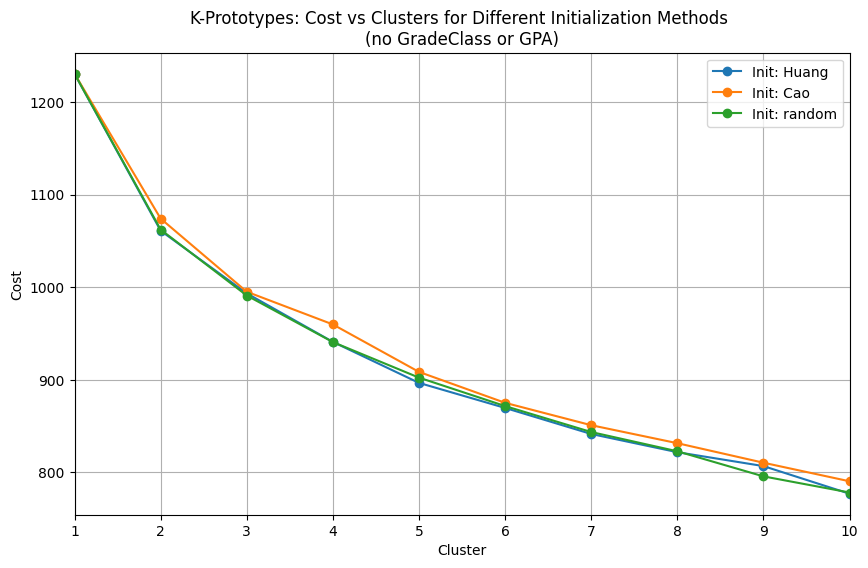

In [18]:
from kmodes.kprototypes import KPrototypes
import pandas as pd


plot_data_dict = {}

cat_cols_idx = [i for i, col in enumerate(dfc_no_GC_GPA.columns) 
                if (col in categorical_cols) and (col not in ordinal_cols)]

for init in ["Huang", "Cao", "random"]:
    kptypes_list = list()

    for clust in range(1,11):
        kptypes = KPrototypes(n_clusters=clust, init=init, n_init=10, n_jobs=-1, random_state=42, max_iter=10000)
        kptypes = kptypes.fit(dfc_no_GC_GPA, categorical=cat_cols_idx)
        kptypes_list.append(pd.Series({'clusters': clust, 
                                    'cost': kptypes.cost_,
                                    'model': kptypes}))


    plot_data = (pd.concat(kptypes_list, axis=1)
                .T
                [['clusters','cost']]
                .set_index('clusters'))
    
    plot_data_dict[init] = plot_data


plt.figure(figsize=(10, 6))
for init, plot_data in plot_data_dict.items():
    plt.plot(plot_data.index, plot_data['cost'], marker='o', linestyle='-', label=f'Init: {init}')

plt.xticks(range(0, 11, 1))
plt.xlim(1, 10)
plt.xlabel('Cluster')
plt.ylabel('Cost')
plt.title('K-Prototypes: Cost vs Clusters for Different Initialization Methods \n(no GradeClass or GPA)')
plt.legend()
plt.grid(True)
plt.show()

Our cost has risen slightly compared to before, where we had `GPA` included.

We also seem to have lost any real discernible elbows.

#### K-Modes/K-prototypes Conclusions

Between K-Modes and K-Prototypes, we had a few elbows in various places along our different curves. We had elbows between 4 and 8 clusters (inclusive).

We may expect to see elbows around 5 clusters, but we had more discernible elbows around 7 and 8 clusters. This is interesting to see, as we might be capturing some more nuances in the data compared to the simple `GradeClass`-based groupings.

Given how low we were able to get our cost with k-prototypes, it might be a better choice of model compared to k-modes. This is expected, since we are able to preserve the ordinality of some of our features by treating them as numerical, which k-prototypes can more appropriately handle.

Including at least one of either `GradeClass` or `GPA` would be preferrable when determining our clusters, as it captures some of the students' performance when determining the clusters.

Due to all of these considerations, we will proceed in our model comparisons with the next models using k-prototypes, rather than k-modes. 

### Hierarchical Agglomerative Clustering (with Gower distance metric)

For our hierarchical agglomerative clustering (HAC) model, we will be using the Gower distance metric. Our reason for choosing this metric is that it is able to handle mixed datatypes. 

For assessing the performance of our model, we will be using the `sillhouette_score` from `sklearn.metrics`. This metric (put rather simply) grades the model based on cluster separation using the generated labels. 

- A score of 1 (the highest) indicates perfect cluster separation with no overlap.

- Scores near zero indicates some overlap of our clusters.

- Negative scores (-1 being the lowest) is indicative of mislabelling.

So rather than looking for elbows, we will be looking for peaks in the upcoming plots.

As before, we will begin by including all of our features, and then proceed with two more tests with the same model, but excluding our "targets" ("GradeClass" and "GPA). We will also be treating our ordinal features as numerical, even if they are categorical.

#### HAC model training

First, let's fit and assess a HAC model with all of our columns. 

We specify which columns are to be treated as categorical when calling our `gower_matrix` function.

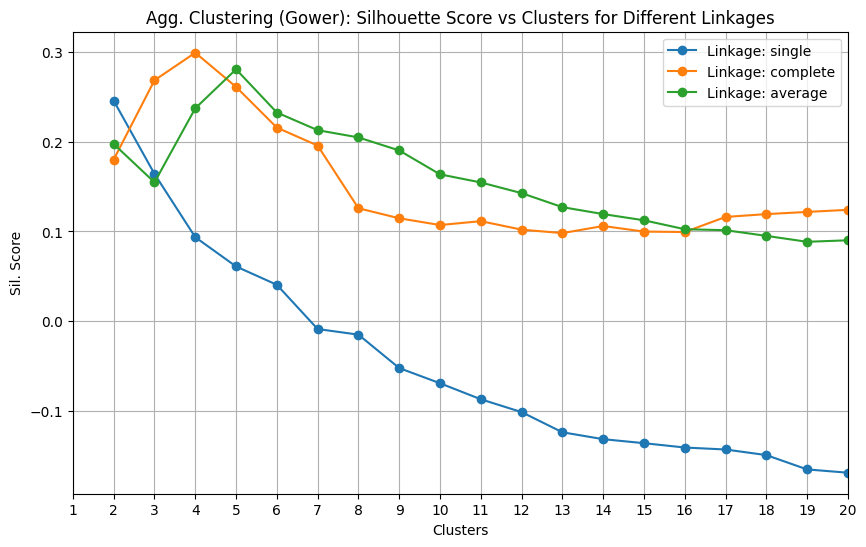

In [19]:
from gower import gower_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


drop_cols = []
dfc_for_gower = dfc.drop(drop_cols)
X = dfc_for_gower.to_numpy()
gower_dist_mat = gower_matrix(
    X,
    cat_features=[True if (col in categorical_cols) and (col not in ordinal_cols)
                  else False
                  for i, col in enumerate(dfc_for_gower.columns)])

agg_clust_plot_data = {}

# linkage can be 'average', 'complete', 'single'
for linkage in ['single', 'complete', 'average']:
    agg_clust_list = list()
    
    # print(f"{linkage} linkage:")
    for n_clust in range(2,21):
        cluster = AgglomerativeClustering(n_clusters=n_clust, metric='precomputed', linkage=linkage)
        cluster.fit_predict(gower_dist_mat)
        score = silhouette_score(gower_dist_mat, cluster.labels_, metric='precomputed')
        # print(f"\t{n_clust} clusters:\t", score)

        agg_clust_list.append(pd.Series({'clusters': n_clust, 
                                    'sil. score': score,
                                    'model': cluster}))
        
    plot_data = (pd.concat(agg_clust_list, axis=1)
                .T
                [['clusters','sil. score']]
                .set_index('clusters'))
    
    agg_clust_plot_data[linkage] = plot_data

plt.figure(figsize=(10, 6))
for linkage, plot_data in agg_clust_plot_data.items():
    plt.plot(plot_data.index, plot_data['sil. score'], marker='o', linestyle='-', label=f'Linkage: {linkage}')

plt.xticks(range(0, 21, 1))
plt.xlim(1, 20)
plt.xlabel('Clusters')
plt.ylabel('Sil. Score')
if drop_cols:
    plt.title('Agg. Clustering (Gower): Silhouette Score vs Clusters for Different Linkages'
                + f'\n(no {drop_cols})')
else:
    plt.title('Agg. Clustering (Gower): Silhouette Score vs Clusters for Different Linkages')
plt.legend()
plt.grid(True)
plt.show()

Single-linkage appears to work rather poorly, as we have a purley decreasing curve. This could indicate some manner of overlap with our clusters.

complete- and average-linkage give us peaks, one at 4 clusters, and 1 at 5 clusters. This is assuring, because these peaks are both around our number of `GradeClass` groups.

Our silhouette scores at these peaks are around 0.29 to 0.30, which means we may have some overlap with our clusters, but the clusters should be separate enough to perform some meaningful analysis.

Let's continue by removing our `GradeClass` column.

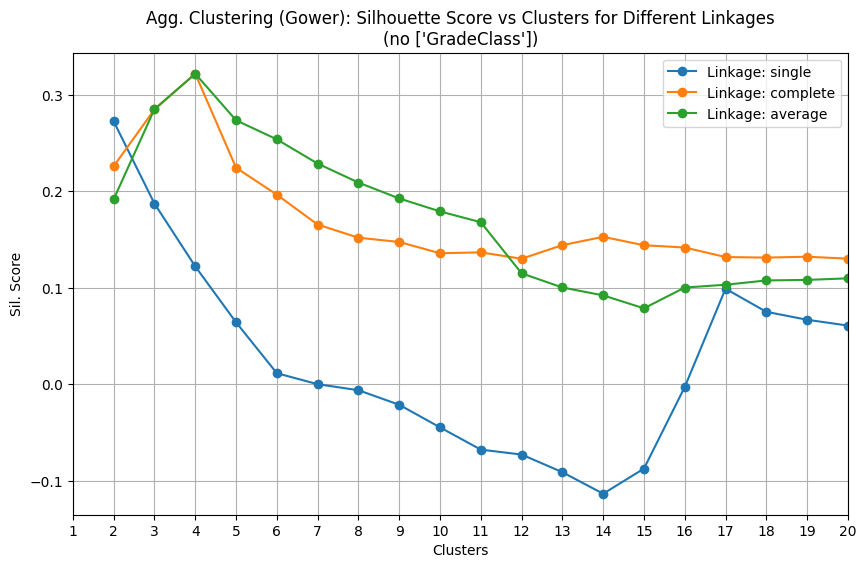

In [20]:
from gower import gower_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


drop_cols = ["GradeClass"]
dfc_for_gower = dfc.drop(drop_cols)
X = dfc_for_gower.to_numpy()
gower_dist_mat = gower_matrix(
    X,
    cat_features=[True if (col in categorical_cols) and (col not in ordinal_cols)
                  else False
                  for i, col in enumerate(dfc_for_gower.columns)])

agg_clust_plot_data = {}

# linkage can be 'average', 'complete', 'single'
for linkage in ['single', 'complete', 'average']:
    agg_clust_list = list()
    
    # print(f"{linkage} linkage:")
    for n_clust in range(2,21):
        cluster = AgglomerativeClustering(n_clusters=n_clust, metric='precomputed', linkage=linkage)
        cluster.fit_predict(gower_dist_mat)
        score = silhouette_score(gower_dist_mat, cluster.labels_, metric='precomputed')
        # print(f"\t{n_clust} clusters:\t", score)

        agg_clust_list.append(pd.Series({'clusters': n_clust, 
                                    'sil. score': score,
                                    'model': cluster}))
        
    plot_data = (pd.concat(agg_clust_list, axis=1)
                .T
                [['clusters','sil. score']]
                .set_index('clusters'))
    
    agg_clust_plot_data[linkage] = plot_data

plt.figure(figsize=(10, 6))
for linkage, plot_data in agg_clust_plot_data.items():
    plt.plot(plot_data.index, plot_data['sil. score'], marker='o', linestyle='-', label=f'Linkage: {linkage}')

plt.xticks(range(0, 21, 1))
plt.xlim(1, 20)
plt.xlabel('Clusters')
plt.ylabel('Sil. Score')
if drop_cols:
    plt.title('Agg. Clustering (Gower): Silhouette Score vs Clusters for Different Linkages'
                + f'\n(no {drop_cols})')
else:
    plt.title('Agg. Clustering (Gower): Silhouette Score vs Clusters for Different Linkages')
plt.legend()
plt.grid(True)
plt.show()

Our peaks for complete- and average-linkage have risen a bit in silhouette score, and now meet at 4 clusters. The higher peak means we have better separation of our clusters ,though marginal.

Interestingly, we appear to have a peak forming around 17 clusters for our sinlge-linkage curve. However, the peak is at a silhouette score of 0.1, so it still may not be very reliable.

Lastly for our HAC tests, let's see what our curves look like by also removing the `GPA` column.

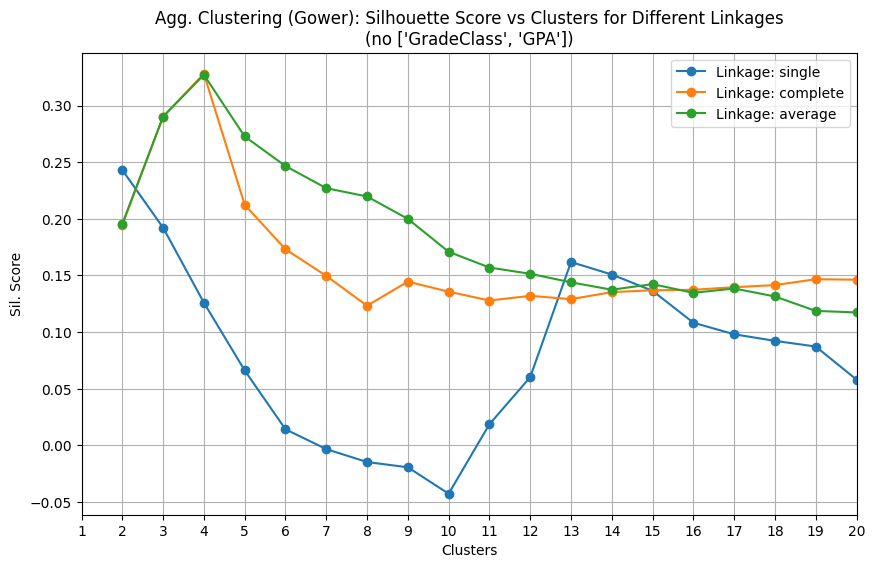

In [21]:
from gower import gower_matrix
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


drop_cols = ["GradeClass", "GPA"]
dfc_for_gower = dfc.drop(drop_cols)
X = dfc_for_gower.to_numpy()
gower_dist_mat = gower_matrix(
    X,
    cat_features=[True if (col in categorical_cols) and (col not in ordinal_cols)
                  else False
                  for i, col in enumerate(dfc_for_gower.columns)])

agg_clust_plot_data = {}

# linkage can be 'average', 'complete', 'single'
for linkage in ['single', 'complete', 'average']:
    agg_clust_list = list()
    
    # print(f"{linkage} linkage:")
    for n_clust in range(2,21):
        cluster = AgglomerativeClustering(n_clusters=n_clust, metric='precomputed', linkage=linkage)
        cluster.fit_predict(gower_dist_mat)
        score = silhouette_score(gower_dist_mat, cluster.labels_, metric='precomputed')
        # print(f"\t{n_clust} clusters:\t", score)

        agg_clust_list.append(pd.Series({'clusters': n_clust, 
                                    'sil. score': score,
                                    'model': cluster}))
        
    plot_data = (pd.concat(agg_clust_list, axis=1)
                .T
                [['clusters','sil. score']]
                .set_index('clusters'))
    
    agg_clust_plot_data[linkage] = plot_data

plt.figure(figsize=(10, 6))
for linkage, plot_data in agg_clust_plot_data.items():
    plt.plot(plot_data.index, plot_data['sil. score'], marker='o', linestyle='-', label=f'Linkage: {linkage}')

plt.xticks(range(0, 21, 1))
plt.xlim(1, 20)
plt.xlabel('Clusters')
plt.ylabel('Sil. Score')
if drop_cols:
    plt.title('Agg. Clustering (Gower): Silhouette Score vs Clusters for Different Linkages'
                + f'\n(no {drop_cols})')
else:
    plt.title('Agg. Clustering (Gower): Silhouette Score vs Clusters for Different Linkages')
plt.legend()
plt.grid(True)
plt.show()

We seem to have very similar curves compared to before, though they're much sharper.

Our peak for the single-linkage curve has risen a bit more, and also shifted to 13 clusters. Seeing these (somewhat dramatic) shifts, we may be able to deduce that a good portion of our clusters' overlap is coming from our `GPA` and `GradeClass` columns. 

This is expected, since some students with similar study habits and extracurricular activity participation will likely have a wide range of grade-based performance. This could be due to innate intelligence, or even some features not included in this dataset.


#### HAC model conclusions

single-linkage appears to work rather poorly for our HAC models, so we may have some significant overlap of desirable clusters.

complete- and average- linkage seems to work well, regardless of how many features we include.

In all cases tested here, we seem to have the best cluster separation around 4 clusters.

We also found that much of our cluster separation could be due to the `GradeClass` and `GPA` columns, as indicated by our single-linkage curves.

All in all, this model seems to be better at separating smaller numbers of clusters more confidently compared to k-prototypes.

As mentioned at the end of the k-modes/k-prototypes model tests, we would like to try and capture the students' grade-based performance when identifying clusters, to try and get some finer categorization of the students (beyond simple `GradeClass` separation).

### DBSCAN

As we did with our HAC training, we will be using the Gower metric. Our reason is the same, in that it handles mixed datatypes well.

We will need to create our plots differently to HAC, as we don't have different linkage types, and we don't have to specify the number of clusters.

Instead, we will be iterating across two parameters for the DBSCAN model: `min_samples` and `epsilon`.

We will still be using the silhouette score, and so on our curves we will still be trying to identify peaks.

#### DBSCAN Model Training

We will begin as before, including all of our columns, and then removing `GradeClass` and `GPA`.

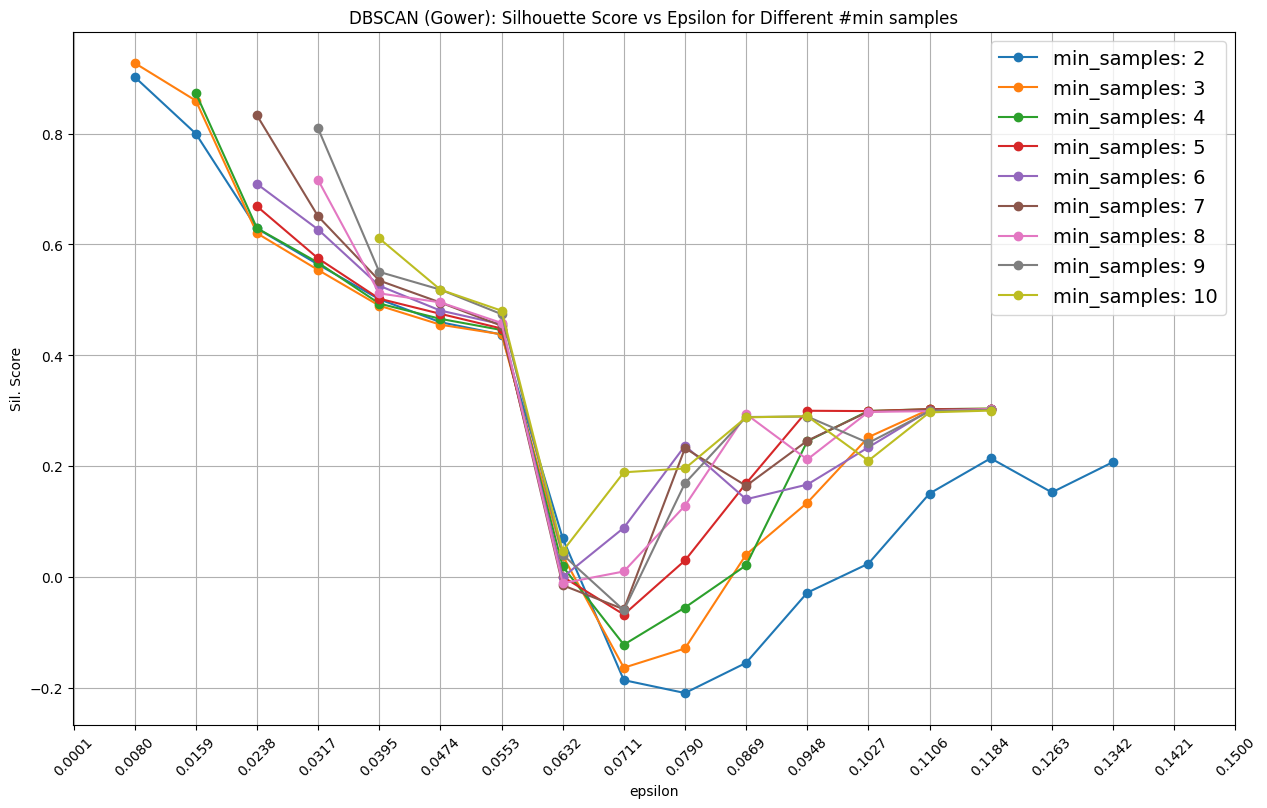

In [22]:
from gower import gower_matrix
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


drop_cols = []
dfc_for_gower = dfc.drop(drop_cols)
X = dfc_for_gower.to_numpy()
gower_dist_mat = gower_matrix(
    X,
    cat_features=[True if (col in categorical_cols) and (col not in ordinal_cols)
                  else False
                  for i, col in enumerate(dfc_for_gower.columns)])

dbscan_plot_data = {}

epsilon_range = np.linspace(0.0001, 0.15, 20)

dbscan_performances = []

# linkage can be 'average', 'complete', 'single'
for min_samples in range(2,11):
    agg_clust_list = list()
    
    for epsilon in epsilon_range:
        cluster = DBSCAN(eps=epsilon, min_samples=min_samples, metric='precomputed', n_jobs=-1)
        cluster.fit_predict(gower_dist_mat)
        try:
            non_noise_mask = cluster.labels_ != -1
            sil_score = silhouette_score(gower_dist_mat[non_noise_mask][:, non_noise_mask], cluster.labels_[non_noise_mask], metric='precomputed')
        except ValueError:
            continue
        performance = [min_samples, epsilon, np.sum(cluster.labels_ == -1), len(np.unique(cluster.labels_[non_noise_mask])), sil_score]
        dbscan_performances.append(performance)


        agg_clust_list.append(pd.Series({'epsilon': epsilon,
                                         'sil. score': sil_score,
                                         'model': cluster}))
        
    plot_data = (pd.concat(agg_clust_list, axis=1)
                .T
                [['epsilon', 'sil. score']]
                .set_index('epsilon'))
    
    dbscan_plot_data[min_samples] = plot_data

dbscan_perf_df = pl.DataFrame(np.array(dbscan_performances))
dbscan_perf_df.columns = ["min_samples", "epsilon", "num_noise", "num_labels", "sil_score"]

plt.figure(figsize=(15, 9))
for min_samples, plot_data in dbscan_plot_data.items():
    plt.plot(plot_data.index, plot_data['sil. score'], marker='o', linestyle='-', label=f'min_samples: {min_samples}')

plt.xticks(epsilon_range)
plt.xticks(rotation=45)
plt.xlim(0, epsilon_range[-1])
plt.xlabel('epsilon')
plt.ylabel('Sil. Score')
if drop_cols:
    plt.title('DBSCAN (Gower): Silhouette Score vs Epsilon for Different #min samples'
                + f'\n(no {drop_cols})')
else:
    plt.title('DBSCAN (Gower): Silhouette Score vs Epsilon for Different #min samples')
plt.legend(prop={'size': 14})
plt.grid(True)
plt.show()

It looks like we have some very high-performaing combinations of parameters! Compared to the silhouette scores we were getting for our HAC model, we're seeing more than double the scores seen for HAC at the peaks of some of these curves.

However, this plot doesn't tell us anything about the number of noise points labelled, or the number of clusters determined.

We have a dataframe that tells us these, along with the parameters that achieved them, as well as the respective silhouette score.

In [23]:
dbscan_perf_df.head(10)

min_samples,epsilon,num_noise,num_labels,sil_score
f64,f64,f64,f64,f64
2.0,0.007989,2270.0,59.0,0.902301
2.0,0.015879,2117.0,127.0,0.799929
2.0,0.023768,1752.0,218.0,0.628803
2.0,0.031658,1513.0,254.0,0.563806
2.0,0.039547,1177.0,302.0,0.501116
2.0,0.047437,935.0,309.0,0.459594
2.0,0.055326,695.0,320.0,0.437297
2.0,0.063216,568.0,239.0,0.069418
2.0,0.071105,406.0,153.0,-0.186588


We can already see that some of these model configurations yield strange results.

Some have >80% of the 2392 samples labelled as noise, and some have dozens to hundreds of unique clusters.

Let's take a look at the top 20 cases based on silhouette score.

In [25]:
pl.Config.set_tbl_rows(20)
dbscan_perf_df.sort("sil_score", descending=True).head(20)

min_samples,epsilon,num_noise,num_labels,sil_score
f64,f64,f64,f64,f64
3.0,0.007989,2380.0,4.0,0.927476
2.0,0.007989,2270.0,59.0,0.902301
4.0,0.015879,2379.0,3.0,0.873037
3.0,0.015879,2337.0,17.0,0.859546
7.0,0.023768,2376.0,2.0,0.83287
9.0,0.031658,2371.0,2.0,0.809289
2.0,0.015879,2117.0,127.0,0.799929
8.0,0.031658,2350.0,4.0,0.716238
6.0,0.023768,2347.0,6.0,0.709141


It looks like all of the top 20 performing configurations had very large (>50%) number of our samples labelled as noise. So unfortunately, the cases with high silhouette scores are not useful to us.

Let's do some further filtering.

We'll take only cases where the number of labels is less than 20. 20 might be too many labels to be meaningful, but it should narrow down our results enough to spot some useful parameter combinations.

From there, we'll filter out an cases where more than 1/3 of the samples were classified as noise.

Lastly, we'll retain only cases with a positive silhouette score, as negative scores are undesirable.

In [26]:
dbscan_df_filtered = dbscan_perf_df.filter(pl.col("num_labels") <= 20)           # remove all rows with more than 20 unique labels
dbscan_df_filtered = dbscan_df_filtered.filter(pl.col("num_noise")/2392 < 0.33)  # remove rows with 33% or more samples labelled as noise points
dbscan_df_filtered = dbscan_df_filtered.filter(pl.col("sil_score") > 0.0)        # keep only rows with a positive silhouette score
pl.Config.set_tbl_rows(20)
dbscan_df_filtered.sort("sil_score", descending=True).head(20)

min_samples,epsilon,num_noise,num_labels,sil_score
f64,f64,f64,f64,f64
4.0,0.118442,60.0,4.0,0.303522
3.0,0.118442,50.0,4.0,0.30346
8.0,0.118442,96.0,4.0,0.302985
5.0,0.118442,68.0,4.0,0.302746
4.0,0.110553,87.0,4.0,0.302586
5.0,0.110553,99.0,4.0,0.302528
6.0,0.118442,83.0,4.0,0.302423
3.0,0.110553,72.0,4.0,0.302359
7.0,0.118442,89.0,4.0,0.302282


Interestingly, the top 20 scoring configurations all have the same number of labels identified (4). Also, our number of noise points is looking a lot more reasonable.

The silhouette scores for all these configurations are comparable (within 0.006), and so we could likely glean useful information from all of these. Particularly, we may be able to get some insight into what the model is considering "noise", as we get a wide range of total noise points. 

The silhouette scores for all of these are also very similar to those found in our HAC model configurations, and the peak scores were identified at 4 clusters for both DBSCAN and HAC.

Let's rerun this model training, but remove our potential target labels. We'll go ahead and remove `GradeClass` *and* `GPA`, since `GradeClass` is purely dependent on `GPA`.

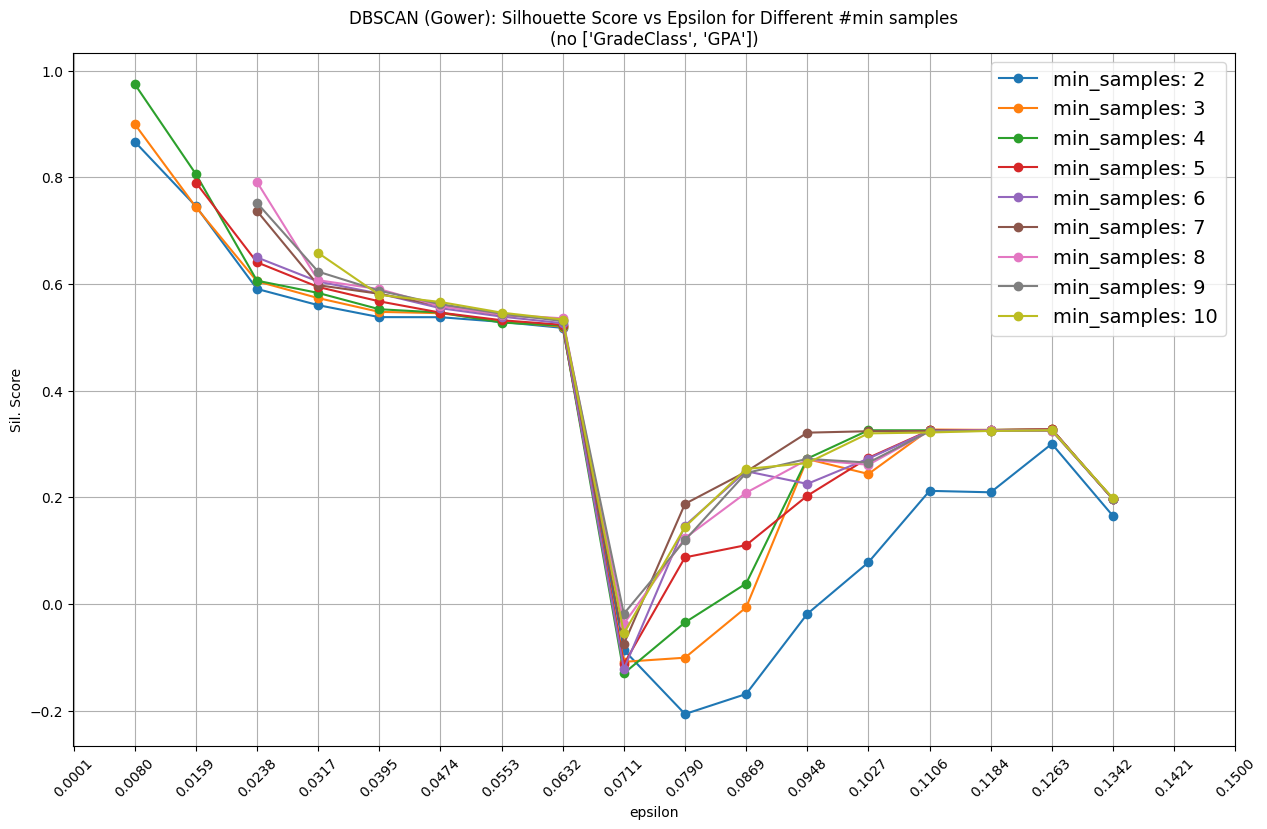

In [27]:
from gower import gower_matrix
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score


drop_cols = ["GradeClass", "GPA"]
dfc_for_gower = dfc.drop(drop_cols)
X = dfc_for_gower.to_numpy()
gower_dist_mat = gower_matrix(
    X,
    cat_features=[True if (col in categorical_cols) and (col not in ordinal_cols)
                  else False
                  for i, col in enumerate(dfc_for_gower.columns)])

dbscan_plot_data = {}

epsilon_range = np.linspace(0.0001, 0.15, 20)

dbscan_performances = []

# linkage can be 'average', 'complete', 'single'
for min_samples in range(2,11):
    agg_clust_list = list()
    
    # print(f"{linkage} linkage:")
    for epsilon in epsilon_range:
        cluster = DBSCAN(eps=epsilon, min_samples=min_samples, metric='precomputed', n_jobs=-1)
        cluster.fit_predict(gower_dist_mat)
        try:
            non_noise_mask = cluster.labels_ != -1
            sil_score = silhouette_score(gower_dist_mat[non_noise_mask][:, non_noise_mask], cluster.labels_[non_noise_mask], metric='precomputed')
            # print(min_samples, f'{epsilon:.5f}', np.sum(cluster.labels_ == -1), len(np.unique(cluster.labels_[non_noise_mask])))
            # sil_score = silhouette_score(gower_dist_mat, cluster.labels_, metric='precomputed')
        except ValueError:
            continue
        performance = [min_samples, epsilon, np.sum(cluster.labels_ == -1), len(np.unique(cluster.labels_[non_noise_mask])), sil_score]
        dbscan_performances.append(performance)
        # dbi_score = davies_bouldin_score()


        agg_clust_list.append(pd.Series({'epsilon': epsilon,
                                         'sil. score': sil_score,
                                         'model': cluster}))
        
    plot_data = (pd.concat(agg_clust_list, axis=1)
                .T
                [['epsilon', 'sil. score']]
                .set_index('epsilon'))
    
    dbscan_plot_data[min_samples] = plot_data

dbscan_perf_df = pl.DataFrame(np.array(dbscan_performances))
dbscan_perf_df.columns = ["min_samples", "epsilon", "num_noise", "num_labels", "sil_score"]

plt.figure(figsize=(15, 9))
for min_samples, plot_data in dbscan_plot_data.items():
    plt.plot(plot_data.index, plot_data['sil. score'], marker='o', linestyle='-', label=f'min_samples: {min_samples}')

plt.xticks(epsilon_range)
plt.xticks(rotation=45)
plt.xlim(0, epsilon_range[-1])
plt.xlabel('epsilon')
plt.ylabel('Sil. Score')
if drop_cols:
    plt.title('DBSCAN (Gower): Silhouette Score vs Epsilon for Different #min samples'
                + f'\n(no {drop_cols})')
else:
    plt.title('DBSCAN (Gower): Silhouette Score vs Epsilon for Different #min samples')
plt.legend(prop={'size': 14})
plt.grid(True)
plt.show()

It looks like the overal silhouette score rose in our curves, but, as mentioned before, this doesn't really tell us anything about the noise points or number of clusters.

In [28]:
dbscan_perf_df.sort("sil_score", descending=True).head(20)

min_samples,epsilon,num_noise,num_labels,sil_score
f64,f64,f64,f64,f64
4.0,0.007989,2384.0,2.0,0.974726
3.0,0.007989,2328.0,20.0,0.899698
2.0,0.007989,2134.0,117.0,0.866718
4.0,0.015879,2311.0,19.0,0.806025
8.0,0.023768,2341.0,6.0,0.791128
5.0,0.015879,2377.0,3.0,0.78997
9.0,0.023768,2373.0,2.0,0.751879
2.0,0.015879,1805.0,247.0,0.745627
3.0,0.015879,2163.0,68.0,0.744117


As expected, the number of noise points and number of labels for our top-performing configurations are all over the place.

Let's perform the same filtering as before.

In [29]:
dbscan_df_filtered = dbscan_perf_df.filter(pl.col("num_labels") <= 20)           # remove all rows with more than 20 unique labels
dbscan_df_filtered = dbscan_df_filtered.filter(pl.col("num_noise")/2392 < 0.33)  # remove rows with 33% or more samples labelled as noise points
dbscan_df_filtered = dbscan_df_filtered.filter(pl.col("sil_score") > 0.0)        # keep only rows with a positive silhouette score
pl.Config.set_tbl_rows(20)
dbscan_df_filtered.sort("sil_score", descending=True).head(20)

min_samples,epsilon,num_noise,num_labels,sil_score
f64,f64,f64,f64,f64
5.0,0.126332,20.0,4.0,0.327544
4.0,0.126332,16.0,4.0,0.327414
3.0,0.126332,12.0,4.0,0.327303
3.0,0.110553,39.0,4.0,0.327044
6.0,0.126332,24.0,4.0,0.326637
3.0,0.118442,26.0,4.0,0.326332
4.0,0.118442,30.0,4.0,0.326241
5.0,0.118442,33.0,4.0,0.326006
6.0,0.118442,38.0,4.0,0.325931


We see a rise in our silhouette score.

We also still have 4 unique clusters as our optimal.

The overall number of noise points per configuration is much lower than the previous test, however.

#### DBSCAN Conclusions

Though we were able to achieve significantly higher silhouette scores compared to the HAC models, many of those configurations were nonsensical, labelling enormous portions of our samples as noise.

After filtering out all of these nonsensical configurations, we found that we had silhouette scores around 0.30 and that our data is best separated into 4 clusters, both of which are consistent with our HAC model findings.

With DBSCAN, it seems we have a lot of viable configurations for splitting our dataset into 4 clusters. This is in contrast to the HAC models, as DBSCAN offers more parameters to fine-tune. Attempting to assess all of these configurations could give us even more valuable information compared to the HAC models, however.

## Conclusions and Considerations for Further Evaluation

Our k-modes and k-prototypes model testing revealed that k-prototypes was the better choice of the two. This is expected, since k-prototypes is better equipped to handle mixed datatypes, and include feature properties such as ordinality. Additionally, we were able to identify a few different viable values for our number of clusters, and so assessing each could give us insight into some novel ways to split up our samples.

Hierarchical Agglomerative Clustering (HAC) techniques revealed that around 4 or 5 clusters offered optimal separation. With our peak silhouette score being around 0.31, we can assume that by separating our samples into 4 clusters offers some decent separation, but some overlap is to be expected. Unfortunately, since we used the silhouette score for assessing the HAC models and inertia for the k-prototypes, it is difficult to compare the performance of the two. However, the results of the k-prototypes training might point us towards some viable number of clusters to use for further analysis into the HAC model's clusters.

The DBSCAN model training yielded similar results to those of the HAC model. In both cases, 4 clusters was deemed ideal, and both had comparable silhouette scores. The DBSCAN model, however, offers much more versatility, in that we can get many different configurations for separating the samples into 4 different clusters. Assessing each of those configurations may be able to revela much more valuable information than using HAC. Additionally, DBSCAN's ability to filter potential noise points gives us much more insight into how the samples could be reasonably clustered.

Overall, I think DBSCAN is the best choice of these three model types. Though its performance is comparable to HAC, it offers much more verstility, since we have many configurations that are comparable in performance, and we have the ability to filter out noise.

-----

Given many of our features were categorical, it was difficult to determine what the ideal engineered features ought to have been. Exploring alternative feature engineering options may offer better performance.

Since our features contained mixed datatypes, it may also be worth exploring model training on just numerical/ordinal features, and excluding the purely categorical ones. This would allow us to use a wider variety of metrics for both the HAC and DBSCAN models. 

Comparing these models to dimensionality reduction techniques, such as nonnegative matrix factorization, could be valuable as well.

# Summary

If you would like to see the plots described in the sections below, please seek out the respective sections in the above notebook.

## Describing the Data

We will be using the [Students Performance Dataset](https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset/data) from Kaggle.

Our dataset includes 2392 rows, and 15 columns.

Features:

- `StudentID` : A unique identifier assigned to each student (1001 to 3392)

- `Age` : The age of the student (ranges from 15 to 18 years old)

- `Gender` : the gender of the student (0: male, 1: female)

- `Ethnicity` : The ethnicity of the student (coded as: 0-caucasian, 1-African American, 2-Asian, 3-other)

- `ParentalEducation` : The highest education level achieved by the student's parent (0: None, 1: High School, 2: Some College, 3: Bachelor's, 4: Higher)

- `StudyTimeWeekly` : The time spent weekly on studying (in hours)

- `Absences` : The number of absences during the school year

- `Tutoring` : Whether the student is receiving tutoring (0: No, 1: Yes)

- `ParentalSupport` : The degree of support offered to the student by the parents (ranges from 0 to 4; 0 being none, 4 being very high)

- `Extracurricular` : Whether the student participates in any extracurricular activity (0: No, 1: Yes)

- `Sports` : Whether the student participates in a sport (0: No, 1: Yes)

- `Music` : Whether the student participates in music activities (0: No, 1: Yes)

- `Volunteering` : Whether the student participates in volunteering (0: No, 1: Yes)

- `GPA` : The grade point average of the student (4.0 scale)

- `GradeClass` : A classification of the students' grades based on GPA (
    0: 'A' (GPA >= 3.5)
    1: 'B' (3.0 <= GPA < 3.5)
    2: 'C' (2.5 <= GPA < 3.0)
    3: 'D' (2.0 <= GPA < 2.5)
    4: 'F' (GPA < 2.0))

Let's group our columns by type, and decide what might be necessary to do with each group.

- binary features: Gender, Tutoring, Extracurricular, Sports, Music, Volunteering

- other categorical: Age, Ethnicity

- ordinal: ParentalEducation, ParentalSupport, GradeClass

- numerical: StudyTimeWeekly, Absences, GPA

All of our binary features, aside from Gender, could potentially be combined into a single numerical feature representing the degree of activity outside of school. In an attempt to try and capture the importances of each of these categories, however, we will keep them as they are.

Age is a bit of a weird one. It can be thought of to behave similarly to gender or ethnicity in this case, since the influence its magnitude may have on the other features isn't clear. In some cases, it could be seen as categorical.
The values within our 

Ethnicity column are each distinct, and there's no ordinal nature to them. Because of this, we will end up one-hot encoding these.

Our "ordinal" columns can be treated as numerical, as a higher value generally means "more" or "better" for these. The GradeClass column, however, is ordered in reverse, so we will reverse the scale for consistency with the GPA scale.

StudyTimeWeekly, Absences, and GPA are all well understood numerical features, and so we will simply scale these as necessary for the models we will be employing. 

## Objective

We will be attempting to identify clusters of students based on a variety of features. (more in the "Loading and Describing our Dataset" section)

We will incorporate three different model types, evaluate their performance, and ultimately select the model best suited to describing our dataset. Since we will be using different metrics for each model, we will use one of our columns that may serve as a reference point for the number of clusters expected. We will also attempt to assess the flexibility of the model, and see if it can potentially identify clusters outside our those of our reference column.

The model types we will be testing include: K-Modes/K-Prototypes clustering, Hierarchical Clusetering (Gower metric), and DBSCAN (Gower metric).

## Models Used and Results

Since our columns include potential class labels in the `GradeClass` column, we perform model training with *and* without this column.

The `GradeClass` column depends purely on the `GPA` column, so we also exclude this one in a third training session for each model.

### K-Modes / K-Prototypes

For k-modes, we were not able to include all of our columns, as some are purely numerical features which are not well-handled by k-modes.

We tested k-modes with 3 different initialization methods: Huang, Cao, and random. Though k-modes does not use inertia, it does have a cost value, which works similarly.

Our first test of k-modes (including `GradeClass`) revealed very slight elbows at 6 and 7 clusters for different initialization methods. Overall, the cost was fairly large, roughly on the order of 10^5.

Excluding the `GradeClass` column, k-modes saw a drop in its overall cost. Additionally, we lost our previously-identified elbows, though one very slight elbow was spotted at 8 clusters for the Huang initialization.

K-prototypes allowed us to include our numerical features, as well as retain the property of ordinality for our ordinal-categorical features by treating them as numerical.

The results of the first test (including `GradeClass`) revealed two important differences compared to our k-modes tests: we had a drastic (~90%) reduction in our overall cost, and the elbows became *much* less discernible. One potential elbow was noted at 8 clusters for the Huang initialization method, but each of the curves were much smoother than those seen in k-modes.

The second test (removing `GradeClass`) showed a slight elbow at 7 clusters for our Huang initialization method, but still no other elbows for our other curves. A similar drop in cost compared to k-modes was noted in this second test.

A third test was performed for k-prototypes, since we were able to include the `GPA` column. Our choice in removing `GPA` was purely because the `GradeClass` column, which could serve as labels for the dataset, is entirely dependent on the `GPA` column.

Between K-Modes and K-Prototypes, we had a few elbows in various places along our different curves. We had elbows between 4 and 8 clusters (inclusive).

We may expect to see elbows around 5 clusters, but we had more discernible elbows around 7 and 8 clusters. This is interesting to see, as we might be capturing some more nuances in the data compared to the simple `GradeClass`-based groupings.

Given how low we were able to get our cost with k-prototypes, it might be a better choice of model compared to k-modes. This is expected, since we are able to preserve the ordinality of some of our features by treating them as numerical, which k-prototypes can more appropriately handle.

Including at least one of either `GradeClass` or `GPA` would be preferrable when determining our clusters, as it captures some of the students' performance when determining the clusters.

Due to all of these considerations, we will proceed in our model comparisons with the next models using k-prototypes, rather than k-modes. 

### Hierarchical Agglomerative Clustering (HAC) with Gower metric

For our hierarchical agglomerative clustering (HAC) model, we will be using the Gower distance metric. Our reason for choosing this metric is that it is able to handle mixed datatypes. 

For assessing the performance of our model, we used the `sillhouette_score` from `sklearn.metrics`. This metric (put rather simply) grades the model based on cluster separation using the generated labels. 

- A score of 1 (the highest) indicates perfect cluster separation with no overlap.

- Scores near zero indicates some overlap of our clusters.

- Negative scores (-1 being the lowest) is indicative of mislabelling.

So rather than looking for elbows, we looked for peaks in the upcoming plots.

As before, we began by including all of our features, and then proceed with two more tests with the same model, but excluding our "targets" ("GradeClass" and "GPA). We will also treated our ordinal features as numerical, even if they are categorical.

For our first test (including all columns), single-linkage appears to work rather poorly, as we have a purley decreasing curve. This could indicate some manner of overlap with our clusters.
Complete- and average-linkage gave us peaks, one at 4 clusters, and 1 at 5 clusters. This is assuring, because these peaks are both around our number of `GradeClass` groups.
Our silhouette scores at these peaks are around 0.29 to 0.30, which means we may have some overlap with our clusters, but the clusters should be separate enough to perform some meaningful analysis.

Our complete- and average-linkage peaks for our second test rose a bit in silhouette score, and met at 4 clusters. The higher peaks mean we had better separation of our clusters,though marginal.
Interestingly, we had a peak form around 17 clusters for our sinlge-linkage curve. However, the peak was at a silhouette score of 0.1, so it still may not be very reliable.

In our final HAC test (no `GradeClass` or `GPA`), we had very similar curves compared to before, though they were much sharper.
Our peak for the single-linkage curve rose a bit more, and also shifted to 13 clusters. Seeing these (somewhat dramatic) shifts, we may be able to deduce that a good portion of our clusters' overlap is coming from our `GPA` and `GradeClass` columns. 

This was expected, since some students with similar study habits and extracurricular activity participation will likely have a wide range of grade-based performance. This could be due to innate intelligence, or even some features not included in this dataset.

### DBSCAN with Gower Metric

As we did with our HAC training, we used the Gower metric. Our reason was the same, in that it handles mixed datatypes well.

We needed to create our plots differently to HAC, as we didn't have different linkage types, and we didn't have to specify the number of clusters.

Instead, we iterated across two parameters for the DBSCAN model: `min_samples` and `epsilon`.

We still used the silhouette score, and so on our curves we identified peaks.

We iterated across a range of 2-10 for `min_samples`, and 10 different values in a narrow window for `epsilon`.

The first set of curves (with all columns included), showed a substantial increase in our silhouette score (>0.9). However, these values alone did not tell us much, as we would need to inspect the clusters identified, as well as the number of noise points labelled.
In all of the high-performing cases, we noted that a large majority of the samples (>80%) were being flagged as noise, and we were getting large numbers of unique clusters (dozens to hundreds). Since these results were largely nonsensical, we performed some filtering on our results to try and find some within more acceptable ranges. After filtering for lower proportions of noise to non-noise points and cases with less than 20 unique clusters, we found many configurations for the model that were much more reasonable (see below for an example). All of the filtered cases had 4 clusters, and a silhouette score around 0.3. This was very comparable to our HAC model tests. 

The second test (exlcuding both `GradeClass` and `GPA`) gave us a higher peak silhouette score compared to the first test. All the high-performing cases again had similarly nonsensical results. 

Though we were able to achieve significantly higher silhouette scores compared to the HAC models, many of those configurations were nonsensical, labelling enormous portions of our samples as noise. After filtering, we were able to spot similar optimum clustering, as well as much lower overal noise points.

After filtering out all of these nonsensical configurations, we found that we had silhouette scores around 0.30 and that our data is best separated into 4 clusters, both of which are consistent with our HAC model findings.

With DBSCAN, it seems we have a lot of viable configurations for splitting our dataset into 4 clusters. This is in contrast to the HAC models, as DBSCAN offers more parameters to fine-tune. Attempting to assess all of these configurations could give us even more valuable information compared to the HAC models, however.

In [31]:
# before filtering

pl.Config.set_tbl_rows(10)
dbscan_perf_df.sort("sil_score", descending=True).head(10)

min_samples,epsilon,num_noise,num_labels,sil_score
f64,f64,f64,f64,f64
4.0,0.007989,2384.0,2.0,0.974726
3.0,0.007989,2328.0,20.0,0.899698
2.0,0.007989,2134.0,117.0,0.866718
4.0,0.015879,2311.0,19.0,0.806025
8.0,0.023768,2341.0,6.0,0.791128
5.0,0.015879,2377.0,3.0,0.78997
9.0,0.023768,2373.0,2.0,0.751879
2.0,0.015879,1805.0,247.0,0.745627
3.0,0.015879,2163.0,68.0,0.744117


In [33]:
# after filtering

dbscan_df_filtered = dbscan_perf_df.filter(pl.col("num_labels") <= 20)           # remove all rows with more than 20 unique labels
dbscan_df_filtered = dbscan_df_filtered.filter(pl.col("num_noise")/2392 < 0.33)  # remove rows with 33% or more samples labelled as noise points
dbscan_df_filtered = dbscan_df_filtered.filter(pl.col("sil_score") > 0.0)        # keep only rows with a positive silhouette score
pl.Config.set_tbl_rows(10)
dbscan_df_filtered.sort("sil_score", descending=True).head(10)

min_samples,epsilon,num_noise,num_labels,sil_score
f64,f64,f64,f64,f64
5.0,0.126332,20.0,4.0,0.327544
4.0,0.126332,16.0,4.0,0.327414
3.0,0.126332,12.0,4.0,0.327303
3.0,0.110553,39.0,4.0,0.327044
6.0,0.126332,24.0,4.0,0.326637
3.0,0.118442,26.0,4.0,0.326332
4.0,0.118442,30.0,4.0,0.326241
5.0,0.118442,33.0,4.0,0.326006
6.0,0.118442,38.0,4.0,0.325931


## Findings and Conclusions

Our k-modes and k-prototypes model testing revealed that k-prototypes was the better choice of the two. This is expected, since k-prototypes is better equipped to handle mixed datatypes, and include feature properties such as ordinality. Additionally, we were able to identify a few different viable values for our number of clusters, and so assessing each could give us insight into some novel ways to split up our samples.

Hierarchical Agglomerative Clustering (HAC) techniques revealed that around 4 or 5 clusters offered optimal separation. With our peak silhouette score being around 0.31, we can assume that by separating our samples into 4 clusters offers some decent separation, but some overlap is to be expected. Unfortunately, since we used the silhouette score for assessing the HAC models and inertia for the k-prototypes, it is difficult to compare the performance of the two. However, the results of the k-prototypes training might point us towards some viable number of clusters to use for further analysis into the HAC model's clusters.

The DBSCAN model training yielded similar results to those of the HAC model. In both cases, 4 clusters was deemed ideal, and both had comparable silhouette scores. The DBSCAN model, however, offers much more versatility, in that we can get many different configurations for separating the samples into 4 different clusters. Assessing each of those configurations may be able to revela much more valuable information than using HAC. Additionally, DBSCAN's ability to filter potential noise points gives us much more insight into how the samples could be reasonably clustered.

Overall, I think DBSCAN is the best choice of these three model types. Though its performance is comparable to HAC, it offers much more verstility, since we have many configurations that are comparable in performance, and we have the ability to filter out noise.

## Possible Flaws and Considerations for Further Evaluation

Given many of our features were categorical, it was difficult to determine what the ideal engineered features ought to have been. Exploring alternative feature engineering options may offer better performance.

Since our features contained mixed datatypes, it may also be worth exploring model training on just numerical/ordinal features, and excluding the purely categorical ones. This would allow us to use a wider variety of metrics for both the HAC and DBSCAN models. 

Comparing these models to dimensionality reduction techniques, such as nonnegative matrix factorization, could be valuable as well.